# SKILL CRAFT

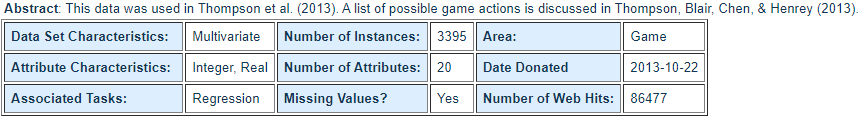

#### Attribute Information:

1. GameID: Unique ID number for each game (integer)
2. LeagueIndex: Bronze, Silver, Gold, Platinum, Diamond, Master, GrandMaster, and Professional leagues coded 1-8 (Ordinal)
3. Age: Age of each player (integer)
4. HoursPerWeek: Reported hours spent playing per week (integer)
5. TotalHours: Reported total hours spent playing (integer)
6. APM: Action per minute (continuous)
7. SelectByHotkeys: Number of unit or building selections made using hotkeys per timestamp (continuous)
8. AssignToHotkeys: Number of units or buildings assigned to hotkeys per timestamp (continuous)
9. UniqueHotkeys: Number of unique hotkeys used per timestamp (continuous)
10. MinimapAttacks: Number of attack actions on minimap per timestamp (continuous)
11. MinimapRightClicks: number of right-clicks on minimap per timestamp (continuous)
12. NumberOfPACs: Number of PACs per timestamp (continuous)
13. GapBetweenPACs: Mean duration in milliseconds between PACs (continuous)
14. ActionLatency: Mean latency from the onset of a PACs to their first action in milliseconds (continuous)
15. ActionsInPAC: Mean number of actions within each PAC (continuous)
16. TotalMapExplored: The number of 24x24 game coordinate grids viewed by the player per timestamp (continuous)
17. WorkersMade: Number of SCVs, drones, and probes trained per timestamp (continuous)
18. UniqueUnitsMade: Unique unites made per timestamp (continuous)
19. ComplexUnitsMade: Number of ghosts, infestors, and high templars trained per timestamp (continuous)
20. ComplexAbilitiesUsed: Abilities requiring specific targeting instructions used per timestamp (continuous)

#### Data Set Information:

- We aggregated screen movements into screen-fixations using a Salvucci & Goldberg (2000) dispersion-threshold algorithm, and defined Perception Action Cycles (PACs) as fixations with at least one action.
- Time is recorded in terms of timestamps in the StarCraft 2 replay file. When the game is played on 'faster', 1 real-time second is equivalent to roughly 88.5 timestamps.
- List of possible game actions is discussed in Thompson, Blair, Chen, & Henrey (2013)


In [443]:
# import most of libraries
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [444]:
# load the dataset
columns = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19)
dataset = pd.read_csv('data/SkillCraft1_Dataset.csv', usecols=columns)

# convert DataFrame to numpy
# the data has missing value
dataset_array = dataset.to_numpy()[:,:]
print(dataset_array)

[[52 5 '27' ... 6 0.0 0.0]
 [55 5 '23' ... 5 0.0 0.00020757]
 [56 4 '30' ... 6 0.0 0.00018876]
 ...
 [10092 8 '?' ... 4 0.0 0.0]
 [10094 8 '?' ... 6 0.0 0.00063141]
 [10095 8 '?' ... 7 0.000456868 0.00089509]]


### DELETE DUPLICATED RECORDS

In [445]:
# delete duplicated elements
dataset_array = np.delete(dataset_array, np.unique(np.where(dataset_array == '?')[0]), axis=0)

In [446]:
# create train samples
train_dataset , test_dataset = train_test_split(dataset_array, shuffle = True, random_state = 42, train_size = 0.8)

### Noramlize

In [447]:
# fetch labels
train_labels = train_dataset[:,4].astype('float64')

# delete the labels from the samples
train_samples = np.delete(train_dataset, 4, axis=1)
train_samples = np.delete(train_samples, 0, axis=1)

print(train_samples)

# normalize
scaled_train_samples = preprocessing.normalize(train_samples).astype('float64')

[[4 '26' '6' ... 9 0.000225946 0.00048665]
 [5 '20' '24' ... 4 0.0 0.0]
 [5 '18' '42' ... 9 0.0 0.0]
 ...
 [4 '21' '12' ... 7 0.0 0.0]
 [5 '17' '42' ... 9 7.87e-05 0.00030514]
 [3 '40' '16' ... 5 0.0 0.0]]


In [448]:
print(scaled_train_samples)

[[2.83836522e-02 1.84493739e-01 4.25754783e-02 ... 6.38632175e-02
  1.60329317e-06 3.45322609e-06]
 [3.53691384e-02 1.41476554e-01 1.69771864e-01 ... 2.82953107e-02
  0.00000000e+00 0.00000000e+00]
 [3.79167855e-02 1.36500428e-01 3.18500998e-01 ... 6.82502139e-02
  0.00000000e+00 0.00000000e+00]
 ...
 [3.81500440e-02 2.00287731e-01 1.14450132e-01 ... 6.67625770e-02
  0.00000000e+00 0.00000000e+00]
 [3.53363473e-02 1.20143581e-01 2.96825317e-01 ... 6.36054251e-02
  5.56194106e-07 2.15650660e-06]
 [2.69214705e-02 3.58952940e-01 1.43581176e-01 ... 4.48691175e-02
  0.00000000e+00 0.00000000e+00]]


## Build The Model

we used Sequential Model for our MLP.

In [449]:
model = Sequential([
    Dense(units=7, input_shape=(train_samples.shape[1],), activation='relu'),
    Dense(units=28, activation='relu'),
    Dense(units=10, activation='relu'),
    Dense(units=1, activation='linear')
])

In [450]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 7)                 133       
                                                                 
 dense_69 (Dense)            (None, 28)                224       
                                                                 
 dense_70 (Dense)            (None, 10)                290       
                                                                 
 dense_71 (Dense)            (None, 1)                 11        
                                                                 
Total params: 658
Trainable params: 658
Non-trainable params: 0
_________________________________________________________________


### compile the model (preprocessing)

In [451]:
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='mean_absolute_error', 
    metrics=['mean_squared_error']
)

### Train the model

In [452]:
model.fit(x=scaled_train_samples, y=train_labels, validation_split=0.1, batch_size=10, epochs=30, shuffle=True, verbose=1)

Epoch 1/30
241/241 [==============================] - 2s 3ms/step - loss: 1059.6780 - mean_squared_error: 417029344.0000 - val_loss: 724.5192 - val_mean_squared_error: 2535160.2500
Epoch 2/30
241/241 [==============================] - 1s 2ms/step - loss: 1058.8798 - mean_squared_error: 417028096.0000 - val_loss: 723.2903 - val_mean_squared_error: 2533444.7500
Epoch 3/30
241/241 [==============================] - 0s 2ms/step - loss: 1057.0024 - mean_squared_error: 417024896.0000 - val_loss: 720.6859 - val_mean_squared_error: 2529786.5000
Epoch 4/30
241/241 [==============================] - 1s 2ms/step - loss: 1053.4663 - mean_squared_error: 417016512.0000 - val_loss: 716.1053 - val_mean_squared_error: 2523327.7500
Epoch 5/30
241/241 [==============================] - 0s 2ms/step - loss: 1047.4034 - mean_squared_error: 417002752.0000 - val_loss: 708.4228 - val_mean_squared_error: 2512489.0000
Epoch 6/30
241/241 [==============================] - 1s 2ms/step - loss: 1037.7231 - mean_squa

### predict

In [453]:
# fetch labels
test_labels = test_dataset[:,4].astype('float64')

# delete the labels from the samples
test_samples = np.delete(test_dataset, 4, axis=1)
test_samples = np.delete(test_samples, 0, axis=1)

print(test_samples)

# normalize
scaled_test_samples = preprocessing.normalize(test_samples).astype('float64')

[[4 '20' '20' ... 7 0.0 5.67e-05]
 [4 '22' '4' ... 5 0.0 0.0]
 [3 '27' '14' ... 8 0.0 0.0]
 ...
 [3 '27' '16' ... 6 0.0 1.83e-05]
 [4 '18' '14' ... 7 0.0 0.0]
 [6 '20' '28' ... 5 0.0 0.0]]


In [454]:
predictions = model.predict(x=scaled_test_samples, batch_size=10, verbose=0)
#print(predictions)

## concolutions

In [455]:
def histogram(y_pred, y_true, n_rows = 1, n_cols = 1, title = 'barstacked'):

    species = ('1', '2')
    fig, axs = plt.subplots(nrows = n_rows, ncols = n_cols)

    axs.hist(y_pred, density = True, histtype = 'barstacked', rwidth=0.8, label='y_pred')
    axs.hist(y_true, density = True, histtype = 'barstacked', rwidth=0.8, label='y_true')
    axs.set_title(title)
    
    axs.set_ylabel('action-per-minute')
    axs.legend(loc='upper left', ncols=2)

    fig.tight_layout()
    plt.show()

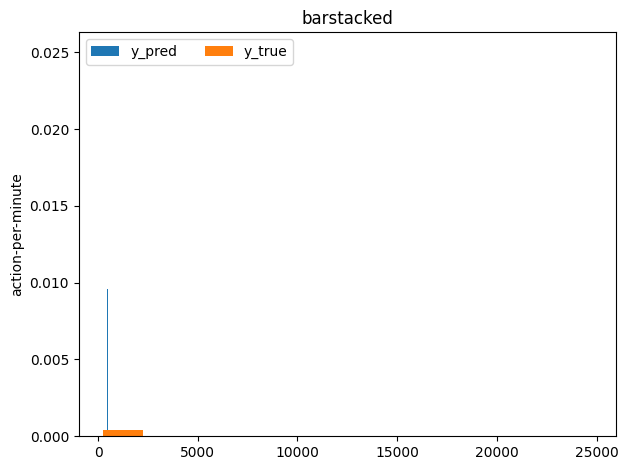

In [456]:
histogram(y_pred = predictions, y_true = test_labels)

In [457]:
def group_bar_chart(species, y_pred, y_true):
    
    penguin_means = {
        'y_pred': np.squeeze(y_pred),
        'y_true': np.squeeze(y_true),
    }

    x = np.arange(len(species))  # the label locations
    width = 0.2  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(1, 1)

    for attribute, measurement in penguin_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel('Length (mm)')
    ax.set_title('Penguin attributes by species')
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(species)
    ax.legend(loc='upper left', ncol=2)
    ax.set_ylim(0, 3000)

    plt.show()

(40,)


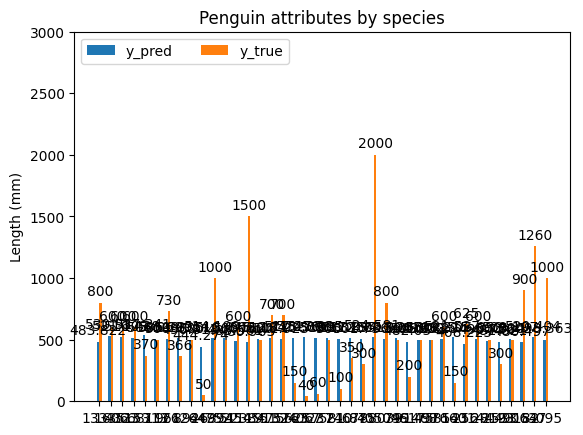

In [458]:
# set offset and limitation
offset = 30
limit = 10

limit = min(offset + limit, len(test_dataset))

# rows
tdataset = np.array([])
tdataset = np.append(arr = tdataset, values = test_dataset[offset : limit + offset,0])

# predicted datas
predict = np.array([])
predict = np.append(arr = predict, values = predictions[offset : limit + offset,0])
    
# true datas
targets = np.array([])
targets = np.append(arr = targets, values = test_labels[offset : limit + offset])

print(tdataset.shape)

# print chart
group_bar_chart(species = tdataset, y_pred = predict, y_true = targets)